In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [24]:
import kagglehub      #I am working on Google Colab, and since uploading the local file was taking too much time, I used the dataset directly from Kaggle. Both are the same, so this works fine.

path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/paysim1


In [25]:
import os

base_path = "/kaggle/input/paysim1"
print("Contents:", os.listdir(base_path))


Contents: ['PS_20174392719_1491204439457_log.csv']


In [27]:
import pandas as pd

base_path = "/kaggle/input/paysim1"
file_path = f"{base_path}/PS_20174392719_1491204439457_log.csv"
df_ = pd.read_csv(file_path)
print("Shape:", df_.shape)
df_.head()



Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [28]:
df=df_

In [33]:
df_.shape

(6362620, 11)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [31]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [12]:
df.duplicated().sum()

np.int64(0)

In [32]:
def create_features(df):
    df['num_transactions_orig'] = df.groupby('nameOrig')['isFraud'].transform('count')
    df['num_transactions_dest'] = df.groupby('nameDest')['isFraud'].transform('count')

    df['amount_to_max_ratio_orig'] = df['amount'] / df.groupby('nameOrig')['amount'].transform('max')

    df['is_first_time_pair'] = ~df.duplicated(subset=['nameOrig', 'nameDest'], keep='first')
    df['is_first_time_pair'] = df['is_first_time_pair'].astype(int)

    df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

    return df
# Create the new feature-engineered DataFrame
df = create_features(df.copy())

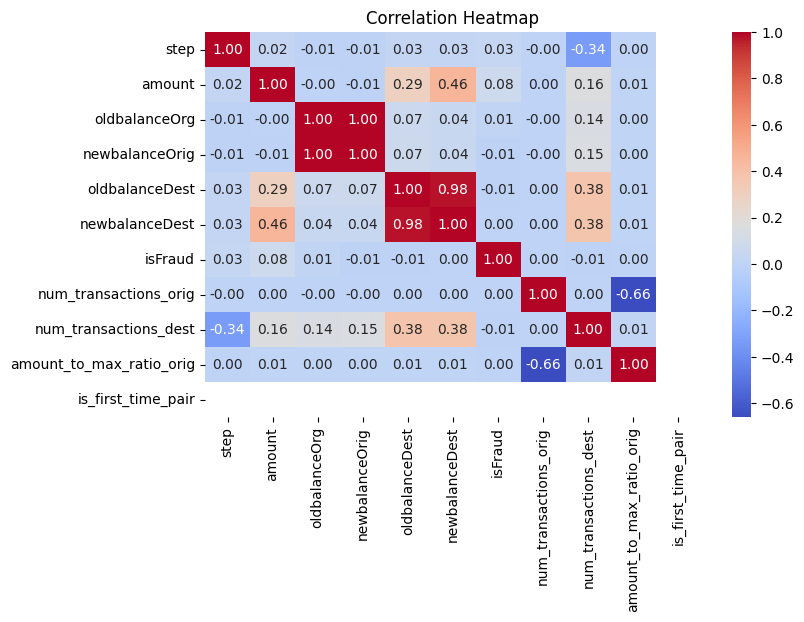

In [34]:
plt.figure(figsize=(8,5))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 1. Data cleaning including missing values, outliers and multi-collinearity.

- No missing values found, so nothing to impute.  
- Dropped `nameOrig` and `nameDest` since they are just IDs and don’t help in fraud detection.  
- I noticed `oldbalanceOrg` and `newbalanceOrig` are highly correlating in heat map, same with `oldbalanceDest` and `newbalanceDest`. To avoid redundancy I keep only one from each pair.  
- Amount and balance columns are right-skewed. For tree models this is fine, but I can still apply a log1p transform for stability.  
- Outliers are not removed because they may represent fraud and tree models handle them well.
- From the `step` column I created new time-based features: `day`, `hour`, and `day_of_week`. This helps capture fraud patterns that depend on time (e.g., more fraud at night or certain days). After creating these, I drop the original `step`



In [13]:
# Drop ID columns
df = df.drop(columns=["newbalanceDest","newbalanceOrig"])

In [14]:
df.shape

(6362620, 9)

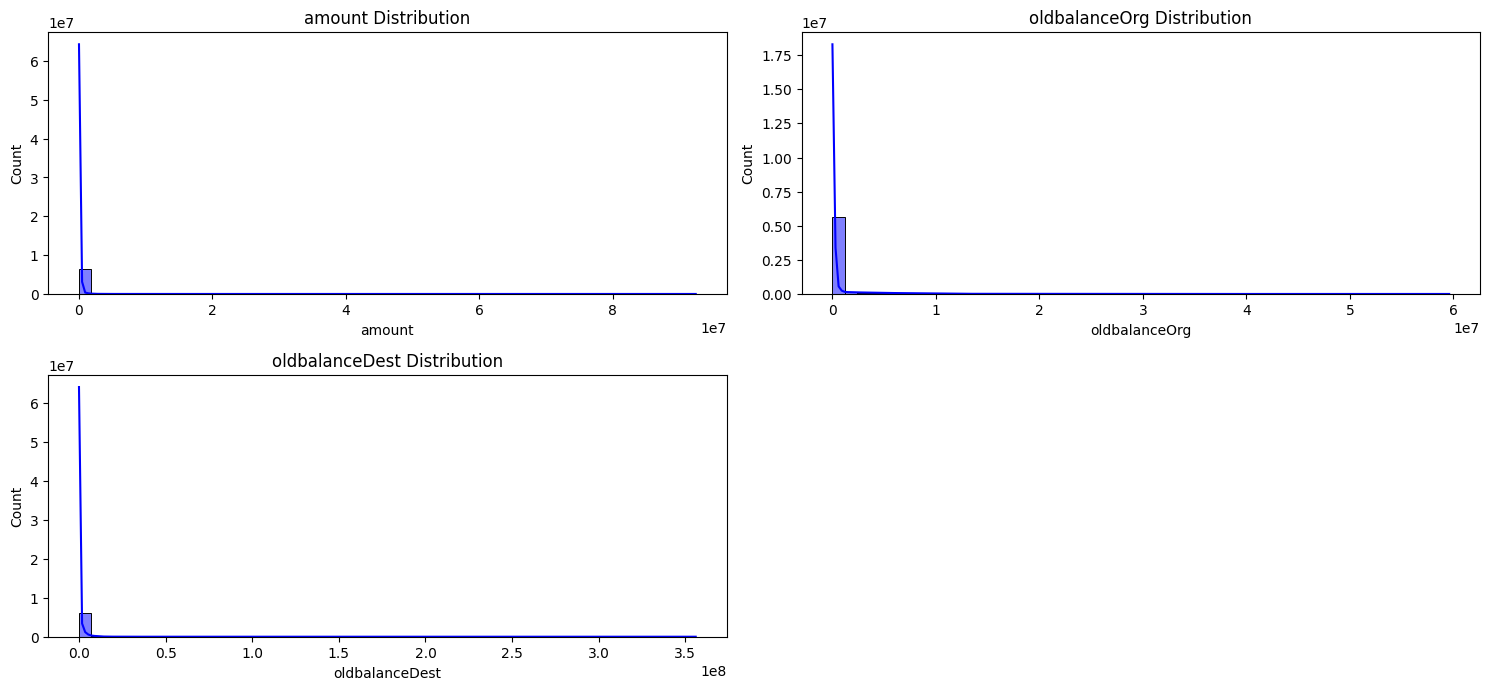

In [ ]:
cols = ['amount', 'oldbalanceOrg','oldbalanceDest']
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=50, kde=True, color='blue')
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()



In [ ]:
# Columns to check
cols = ['amount', 'oldbalanceOrg', 'oldbalanceDest']

# Overwrite the columns with log-transformed values
for col in cols:
    df[col] = np.log1p(df[col])

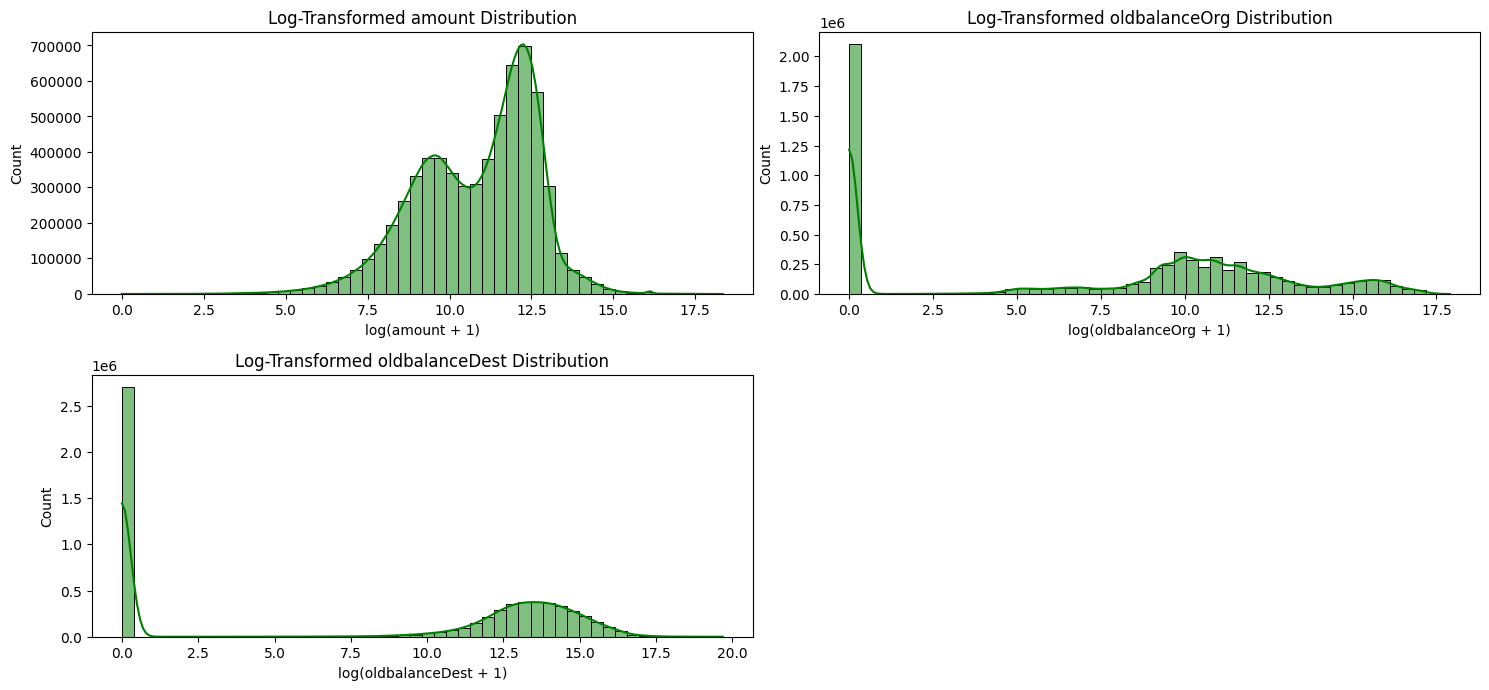

In [ ]:
# Plotting the log-transformed columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=50, kde=True, color='green')
    plt.title(f"Log-Transformed {col} Distribution")
    plt.xlabel(f"log({col} + 1)")

plt.tight_layout()
plt.show()


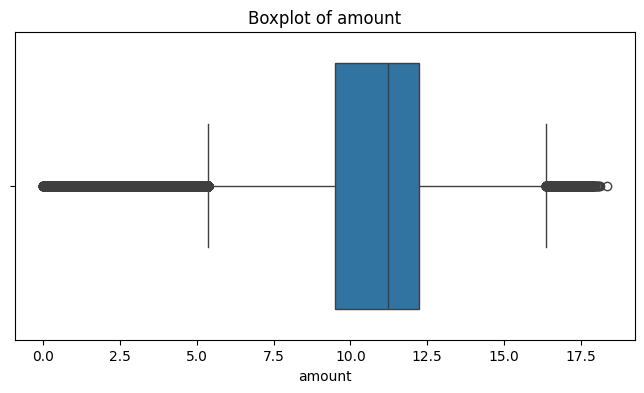

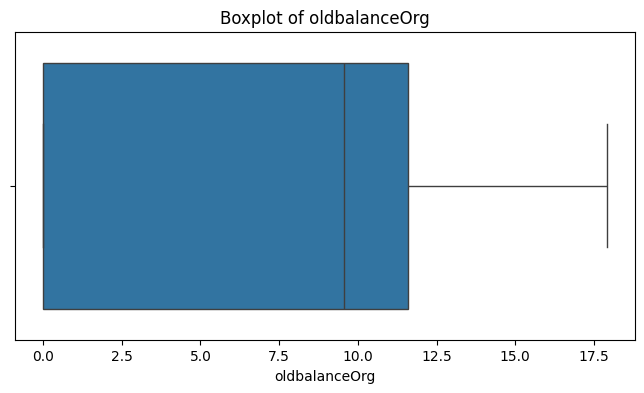

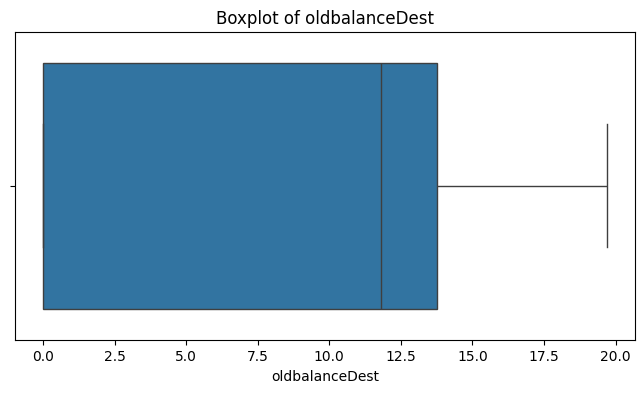

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = ["amount", "oldbalanceOrg", "oldbalanceDest"]

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


Now we are going to deal with cat feature


In [15]:
# Day number (0 = day 1, 1 = day 2, etc.)
df['day'] = df['step'] // 24

# Hour of the day (0–23)
df['hour'] = df['step'] % 24

# Day of week (0 = Monday if dataset starts Monday, but relative anyway)
df['day_of_week'] = df['day'] % 7

In [16]:
df = df.drop(columns=['step'])

In [21]:
df.head(20000000)

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,day,hour,day_of_week,num_transactions_orig,num_transactions_dest,fraud_count_orig,fraud_count_dest,avg_amount_orig,max_amount_orig,total_amount_orig,avg_amount_dest,amount_to_avg_ratio_orig,amount_to_max_ratio_orig,is_first_time_pair
0,PAYMENT,9839.64,170136.00,0.00,0,0,1,0,1,1,0.0,0.0,9839.64,9839.64,9839.64,9.839640e+03,1.0,1.0,1
1,PAYMENT,1864.28,21249.00,0.00,0,0,1,0,1,1,0.0,0.0,1864.28,1864.28,1864.28,1.864280e+03,1.0,1.0,1
2,TRANSFER,181.00,181.00,0.00,1,0,1,0,1,44,1.0,1.0,181.00,181.00,181.00,2.255178e+05,1.0,1.0,1
3,CASH_OUT,181.00,181.00,21182.00,1,0,1,0,1,41,1.0,1.0,181.00,181.00,181.00,4.394442e+05,1.0,1.0,1
4,PAYMENT,11668.14,41554.00,0.00,0,0,1,0,1,1,0.0,0.0,11668.14,11668.14,11668.14,1.166814e+04,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,1,30,23,2,1,2,1.0,1.0,339682.13,339682.13,339682.13,3.323914e+05,1.0,1.0,1
6362616,TRANSFER,6311409.28,6311409.28,0.00,1,30,23,2,1,1,1.0,1.0,6311409.28,6311409.28,6311409.28,6.311409e+06,1.0,1.0,1
6362617,CASH_OUT,6311409.28,6311409.28,68488.84,1,30,23,2,1,3,1.0,1.0,6311409.28,6311409.28,6311409.28,2.212471e+06,1.0,1.0,1
6362618,TRANSFER,850002.52,850002.52,0.00,1,30,23,2,1,1,1.0,1.0,850002.52,850002.52,850002.52,8.500025e+05,1.0,1.0,1


In [18]:
df.describe()

,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,day,hour,day_of_week
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,1.100702e+06,1.290820e-03,2.514687e-06,9.503158e+00,1.532145e+01,2.481576e+00
std,6.038582e+05,2.888243e+06,3.399180e+06,3.590480e-02,1.585775e-03,5.922111e+00,4.321799e+00,2.165331e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.200000e+01,1.000000e+00
50%,7.487194e+04,1.420800e+04,1.327057e+05,0.000000e+00,0.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00
75%,2.087215e+05,1.073152e+05,9.430367e+05,0.000000e+00,0.000000e+00,1.300000e+01,1.900000e+01,5.000000e+00
max,9.244552e+07,5.958504e+07,3.560159e+08,1.000000e+00,1.000000e+00,3.000000e+01,2.300000e+01,6.000000e+00


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   nameDest        object 
 5   oldbalanceDest  float64
 6   isFraud         int64  
 7   isFlaggedFraud  int64  
 8   day             int64  
 9   hour            int64  
 10  day_of_week     int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 534.0+ MB


In [ ]:
df.to_csv("eda_dataframe.csv", index=False)

Now we have to deal with catogorical data and for this I am using column transformer

In [ ]:
# Define column groups
num_features = ["amount", "oldbalanceOrg", "oldbalanceDest", "day", "hour", "day_of_week"]
cat_features = ["type"]
bool_features = ["isFlaggedFraud"]

In [ ]:
# Column Transformer
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', 'passthrough',num_features),
    ('cat', cat_transformer, cat_features),
    ('bool', 'passthrough', bool_features)
])

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

In [ ]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [ ]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df.head()

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,day,hour,day_of_week
0,PAYMENT,9.194276,12.044359,0.000000,0,0,0,1,0
1,PAYMENT,7.531166,9.964112,0.000000,0,0,0,1,0
2,TRANSFER,5.204007,5.204007,0.000000,1,0,0,1,0
3,CASH_OUT,5.204007,5.204007,9.960954,1,0,0,1,0
4,PAYMENT,9.364703,10.634773,0.000000,0,0,0,1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
import time
results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    start_time = time.time()
    pipe.fit(X_train, y_train)  # Train the model
    total_time = time.time() - start_time

    # Predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    # PR-AUC
    if y_pred_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auc_pr = auc(recall, precision)
    else:
        auc_pr = np.nan

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC-AUC': auc_roc,
        'PR-AUC': auc_pr,
        'Train Time (s)': total_time
    })

# Results table
results_df = pd.DataFrame(results).sort_values(by="PR-AUC", ascending=False)
print("\nModel Performance:")
display(results_df)


C:\Users\OM PRAKASH GADHWAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001295 -> initscore=-6.647747
[LightGBM] [Info] Start training from score -6.647747


C:\Users\OM PRAKASH GADHWAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\OM PRAKASH GADHWAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\OM PRAKASH GADHWAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Model Performance:


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,Train Time (s)
3,CatBoost,0.999749,0.938596,0.858642,0.896841,0.998906,0.953185,709.718067
0,Random Forest,0.999576,0.958404,0.696914,0.807005,0.973458,0.867504,404.478547
1,XGBoost,0.999350,0.814433,0.633951,0.712947,0.915380,0.697453,34.003163
2,LightGBM,0.998977,0.599127,0.593210,0.596154,0.818600,0.533343,17.810299


# 2. fraud detection model in elaboration

The fraud detection model is based on **tree-based ensemble methods**, with a strong focus on **CatBoostClassifier** since it efficiently handles categorical features, skewed distributions, and outliers without extensive preprocessing.

- **Preprocessing**:  
  - Encoded the `type` column.  
  - Dropped redundant IDs (`nameOrig`, `nameDest`) and one column from each highly correlated pair (`oldbalanceOrg` vs `newbalanceOrig`, `oldbalanceDest` vs `newbalanceDest`).  
  - Created new time-based features (`day`, `hour`, `day_of_week`) from the `step` column to capture fraud patterns across time.  

- **Model Choice**:  
  Tested Random Forest, XGBoost, LightGBM, and CatBoost. CatBoost performed best for fraud detection due to its robustness with imbalanced data and categorical handling.  

- **Training and Optimization**:  
  Used **Optuna** for hyperparameter tuning (learning rate, depth, iterations, L2 regularization) while optimizing for **Precision-Recall AUC**, which is more suitable than accuracy for highly imbalanced data.  

- **Final Pipeline**:  
  Combined preprocessing and CatBoost into a **Pipeline** for cleaner workflow and reproducibility. This final tuned model is used for predictions and evaluation.


# 3. Selection of the variables

The variable selection process combined **domain understanding**, **statistical checks**, and **feature engineering**:

- **Removed irrelevant IDs**: `nameOrig` and `nameDest` act as unique identifiers and don’t carry fraud-related patterns.  
- **Handled multicollinearity**: Dropped one variable from highly correlated pairs (`oldbalanceOrg` vs `newbalanceOrig`, and `oldbalanceDest` vs `newbalanceDest`) to avoid redundancy.  
- **Kept transaction details**: Features like `amount`, `type`, and account balances are directly related to fraud patterns and must be included.  
- **Time-based features**: From `step`, I created `day`, `hour`, and `day_of_week` since fraud often shows time-related patterns (e.g., unusual transactions late at night).  
- **Target variables**: `isFraud` is the label for supervised learning, while `isFlaggedFraud` is ignored since it is artificially generated by the simulator.  

In short, I selected variables that add **meaningful signal for fraud detection**, removed IDs and redundant columns, and engineered time features to strengthen the model.


In [ ]:
best_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    task_type="GPU",
    devices='0',
    random_state=42,
    verbose=100
)


0:	learn: 0.5170885	total: 46.6ms	remaining: 46.6s
100:	learn: 0.0020132	total: 6.4s	remaining: 57s
200:	learn: 0.0014810	total: 11.4s	remaining: 45.4s
300:	learn: 0.0013211	total: 17.9s	remaining: 41.6s
400:	learn: 0.0012311	total: 22.9s	remaining: 34.2s
500:	learn: 0.0011590	total: 29.2s	remaining: 29.1s
600:	learn: 0.0011036	total: 34.2s	remaining: 22.7s
700:	learn: 0.0010535	total: 41.1s	remaining: 17.5s
800:	learn: 0.0010151	total: 46.4s	remaining: 11.5s
900:	learn: 0.0009790	total: 51.4s	remaining: 5.65s
999:	learn: 0.0009448	total: 58.7s	remaining: 0us


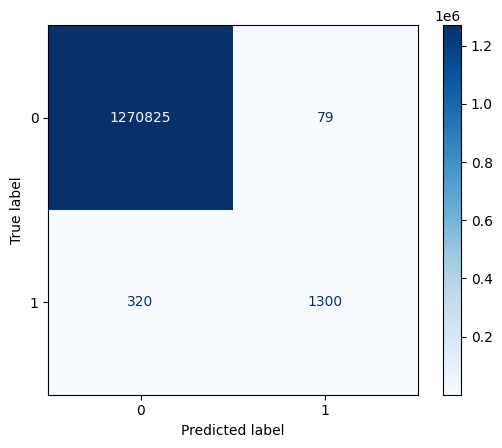

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', best_model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")



In [ ]:
from sklearn import set_config
set_config(display="diagram")

pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
import time
import optuna
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score

# Start timer
start_time = time.time()

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "iterations": trial.suggest_int("iterations", 500, 1200),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 5),
        "auto_class_weights": "Balanced",
        "verbose": 0,
        "random_state": 42,
        "thread_count": -1,
        "task_type": "GPU"

    }
    pipe = Pipeline([
        ('preprocessing', preprocessor),    #-> only categorical encoding in preprocessing
        ("model", CatBoostClassifier(**params))
    ])

    # Fit model
    pipe.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]

    # Compute PR-AUC
    pr_auc = average_precision_score(y_test, y_pred_proba)
    return pr_auc

# Create Optuna study
study = optuna.create_study(direction="maximize", study_name="CatBoost-PR-AUC")
study.optimize(objective, n_trials=10)   #->because it was taking too much time so i am doing it only for 5 trials

# End timer
end_time = time.time()
total_time = end_time - start_time

# Print results
print(f"Best PR-AUC: {study.best_value:.4f}")
print("Best parameters:", study.best_params)
print(f"Total training time: {total_time/60:.2f} minutes")

[I 2025-08-31 11:15:49,719] A new study created in memory with name: CatBoost-PR-AUC
[I 2025-08-31 11:17:03,739] Trial 0 finished with value: 0.9094920917525315 and parameters: {'learning_rate': 0.03918426321734515, 'iterations': 624, 'l2_leaf_reg': 1.9006215528554251}. Best is trial 0 with value: 0.9094920917525315.
[I 2025-08-31 11:18:47,205] Trial 1 finished with value: 0.9014851138992818 and parameters: {'learning_rate': 0.01767708854013817, 'iterations': 1098, 'l2_leaf_reg': 1.3657983693172997}. Best is trial 0 with value: 0.9094920917525315.
[I 2025-08-31 11:20:17,409] Trial 2 finished with value: 0.92570132625235 and parameters: {'learning_rate': 0.09178836235413407, 'iterations': 906, 'l2_leaf_reg': 2.9447220920044157}. Best is trial 2 with value: 0.92570132625235.
[I 2025-08-31 11:22:02,558] Trial 3 finished with value: 0.9216148414764705 and parameters: {'learning_rate': 0.046023916029123965, 'iterations': 986, 'l2_leaf_reg': 2.498941443649431}. Best is trial 2 with value: 0.

Best PR-AUC: 0.9257
Best parameters: {'learning_rate': 0.09178836235413407, 'iterations': 906, 'l2_leaf_reg': 2.9447220920044157}
Total training time: 15.28 minutes


# 4. Demonstration of Model Performance  

The dataset is highly imbalanced (fraud cases are very rare compared to non-fraud), so accuracy alone is not a reliable metric. Instead, I focused on evaluation metrics that are better for imbalanced classification:  

- **Precision**: measures how many of the transactions flagged as fraud are actually fraud.  
- **Recall**: measures how many fraudulent transactions the model successfully detected.  
- **F1-score**: balance between precision and recall.  
- **PR-AUC (Precision-Recall Area Under Curve)**: especially useful in imbalanced datasets as it highlights the trade-off between precision and recall.  
- **ROC-AUC**: overall separability between fraud and non-fraud.  

I also plotted a **Confusion Matrix**, which helps visualize how many transactions were correctly classified as fraud and non-fraud, and where the model made mistakes (false positives and false negatives).  

Since fraud detection is a high-stakes problem, minimizing **False Negatives** is the top priority, because missing a fraud case is more costly than a few false alarms.  

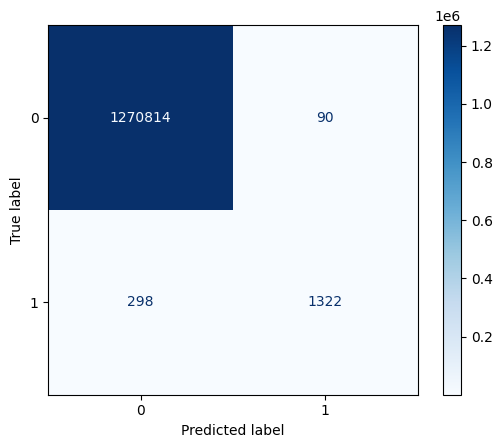

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get best parameters
best_params = study.best_params

# Add fixed parameters (to avoid missing ones)
best_params.update({
    # "auto_class_weights": "Balanced",
    "verbose": 0,
    "random_state": 42,
    "thread_count": -1,
    "task_type": "GPU"
})

# Retrain final model on full training data
final_model = CatBoostClassifier(**best_params)

best_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', final_model)
])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")

320 -> 298 FN after tunning which was the desired

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
# Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)   # needs probabilities
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)

# Optional: detailed per-class metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Precision: 0.9362606232294618
Recall: 0.8160493827160494
F1-score: 0.8720316622691293
ROC-AUC: 0.9987267984243431
PR-AUC: 0.9196678098685283

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.82      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.91      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
from sklearn import set_config
set_config(display="diagram")

best_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['amount', 'oldbalanceOrg',
                                                   'oldbalanceDest', 'day',
                                                   'hour', 'day_of_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type']),
                                                 ('bool', 'passthrough',
                                                  ['isFlaggedFraud'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7db22019b680>)])

In [ ]:
import joblib

# Save pipeline
joblib.dump(best_pipeline, "best_pipeline.pkl")

['best_pipeline.pkl']

# 5. Key Factors Predicting Fraudulent Transactions

                 Feature  Importance
1     num__oldbalanceOrg   34.178575
0            num__amount   33.447055
7     cat__type_CASH_OUT    9.379753
2    num__oldbalanceDest    7.581368
9      cat__type_PAYMENT    4.597430
10    cat__type_TRANSFER    3.226239
3               num__day    2.851792
4              num__hour    2.056961
5       num__day_of_week    1.500164
6      cat__type_CASH_IN    1.180662
8        cat__type_DEBIT    0.000000
11  bool__isFlaggedFraud    0.000000


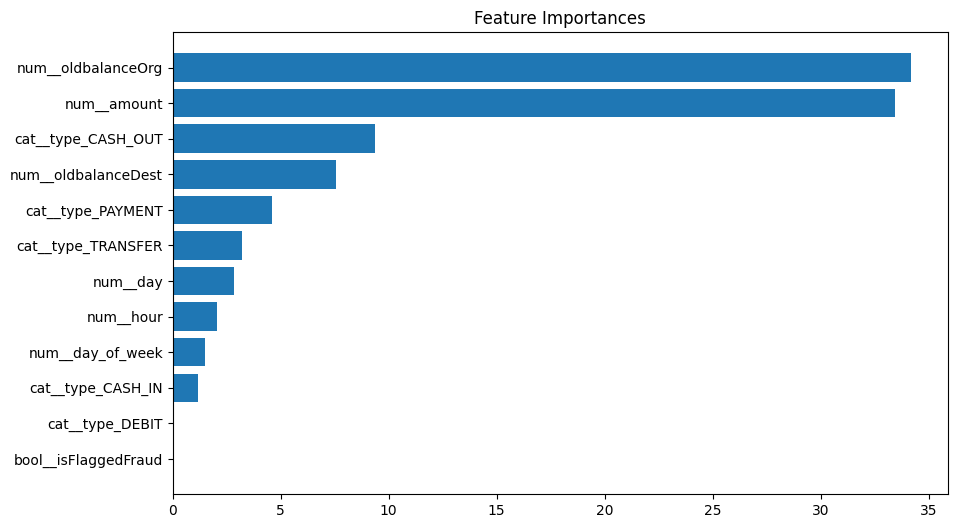

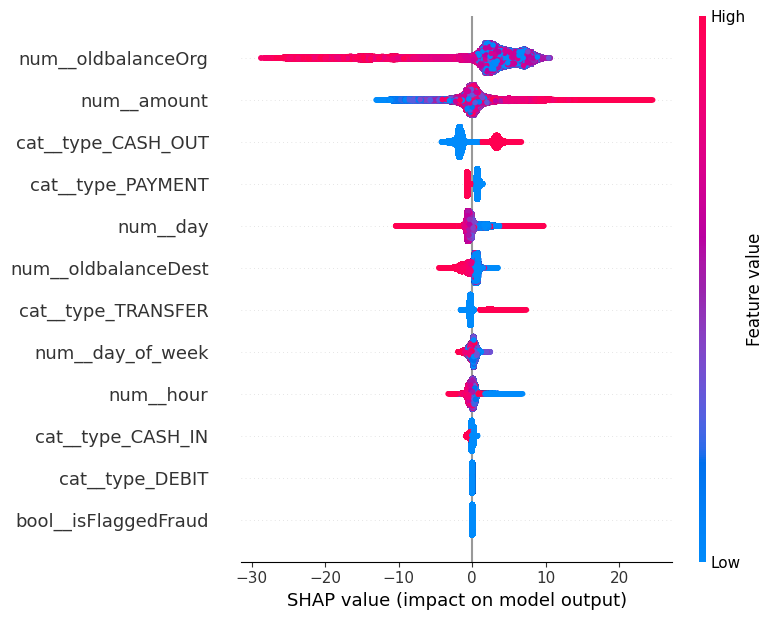

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

# --- Get the trained CatBoost model from pipeline
cat_model = best_pipeline.named_steps['model']

# --- Get feature names (after preprocessing)
feature_names = best_pipeline.named_steps['preprocessing'].get_feature_names_out()

# --- Get feature importance from CatBoost
importances = cat_model.get_feature_importance()
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp.head(15))  # Top 15 features if available

# --- Plot Feature Importance
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"].head(15), feat_imp["Importance"].head(15))
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.show()

# --- SHAP values for detailed explanation
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(best_pipeline.named_steps['preprocessing'].transform(X_test))

shap.summary_plot(shap_values, best_pipeline.named_steps['preprocessing'].transform(X_test),
                  feature_names=feature_names)


# 6. Do These Factors Make Sense?

Yes, they mostly do. Here’s why:  

- **oldbalanceOrg & amount** are on top → This makes sense because fraud often depends on whether the sender’s balance matches the transfer amount. Many fraud cases try to drain accounts.  
- **type_CASH_OUT & type_TRANSFER** are important → Fraud is usually done by cashing out or transferring to mule accounts, which matches real-world fraud patterns.  
- **oldbalanceDest** has moderate importance → The destination account behavior matters, but not as much as the sender’s side.  
- **day, hour, day_of_week** have smaller importance → Timing can reveal odd behaviors (like late-night fraud), but it’s not as strong as money flow.  
- **CASH_IN** is low → Deposits are rarely fraud, so the model correctly treats them as less relevant.  

**What might not make sense?**  
- **isFlaggedFraud at 0** → In real banking, a rule-based fraud flag should carry some signal. If it’s useless here, it’s probably a dataset issue.  



# 7. Prevention Strategies During Infrastructure Update  

I think when a company updates its infrastructure, it should also focus on security and fraud prevention. The company should keep systems up to date with patches, use firewalls, and add multi-factor authentication for safer access. Since fraud is a big risk, real-time monitoring and retraining fraud detection models on new data is important. Backups and recovery plans should also be in place in case something goes wrong. Regular audits and training employees can help reduce mistakes, because many frauds happen due to weak processes or human error. In today’s time, fraudsters keep changing their methods, so these steps make sure the company stays safe during and after the update.  


# 8. Checking if the Actions Work  

To know if these actions are really working, I would check the fraud cases before and after the changes. If the number of frauds goes down and my model is catching them more accurately, then it means the steps are useful. I would also keep an eye on the system in real-time, check the alerts from the model, and do regular audits to see if anything is missed. Even feedback from customers and staff can help in knowing if security is better. Basically, comparing past and present results is the best way to confirm if the actions are effective.  


In [3]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 13.6 MB/s eta 0:00:00
